In [448]:
import glob
import xarray as xr
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
import sys


#Functions

def get_global_weights():
    
     #Get the latitude weights from a special location
    r1 = '/network/group/aopp/predict/TIP016_PAXTON_RPSPEEDY/speedyone/paper/Fig1_10year_Williams/'
    f = r1 + 'speedyoneWILLIAMS_L2_52_RN_10y/model_output00001.nc'
    df = xr.open_dataset(f)
    
    temperature = df.temperature
    #weights = np.cos(np.deg2rad(temperature.latitude))
    #weights.name = "weights"
    
    
    return temperature.latitude



    
def process_nc_file(f,true_latitude,counter):    
    
    #Get data 
    ds = xr.open_dataset(f)
    
        
    #Reset the latitude
    ds = ds.assign_coords(latitude=(true_latitude))
    #And covert longitude to long1
    ds = ds.assign_coords({"longitude": (((ds.longitude + 180) % 360) - 180)})
    
  
    
    
    #Just get the surface temperature
    temperature = ds.temperature
    surface_temperature = temperature[:,0]
    df = surface_temperature.to_dataframe().reset_index()
    
    if df.shape == (1681920,5):
        use = True
    else:
        use=False
    
    df['weight']= np.cos(np.deg2rad(df.latitude))
    df['weighted_temperature']=  df.weight*df.temperature
    
    df_out = df.groupby(['latitude', 'longitude']).mean().reset_index() #i.e. average over 1 year
    df_out['time'] = counter
    return df_out,use
    
    
    
    
    #can also select a single time e.g. df.query("forecast_period == '0 days'")

    
    
def global_average(list_of_files,fname):
    
    """
    Average over all ensemble members (m0,m1 etc) and all times
    """

    
    print ('Processing:')
    #list_of_files = sorted(glob.glob(path)) 
    true_latitude = get_global_weights()
    
    counter = 0
    dfs = []
    for f in tqdm(list_of_files):
    #ll = ['/network/group/aopp/predict/TIP016_PAXTON_RPSPEEDY/speedyone/paper/100year/tmp_m5/speedyone100yr_L2_52_RN_m5/model_output00098.nc']
    #for f in ll:
        
        df,use = process_nc_file(f,true_latitude,counter) #this is a df of the surface temperature for that file, averaged over time
        #print('File', counter , f,df.shape,use)
        if use: #only ue files if they are 'complete' i.e. are not single time snapshots
            counter += 1
            dfs.append(df)
  
    df = pd.concat(dfs)
    
    #groupit
    df_g = df.groupby(['latitude', 'longitude']).mean().reset_index() #i.e. average over all time and ensemble members

    
    #save it
    pd.to_pickle(df_g,fname)
    
    return df_g
    
    
control_files = '/network/group/aopp/predict/TIP016_PAXTON_RPSPEEDY/speedyone/paper/100year/tmp_control/*/model_output*.nc'
competitor_52RN_files = '/network/group/aopp/predict/TIP016_PAXTON_RPSPEEDY/speedyone/paper/100year/tmp_m*/speedyone100yr_L2_52_RN_*/model_output*.nc'
competitor_10SR_files = '/network/group/aopp/predict/TIP016_PAXTON_RPSPEEDY/speedyone/paper/100year/tmp_m*/speedyone100yr_L2_10_SR_*/**/model_output*.nc'


competitor_10RN_files_1 = '/network/group/aopp/predict/TIP016_PAXTON_RPSPEEDY/speedyone/paper/100year/tmp_m*/speedyone100yr_L2_10_RN_*/model_output*.nc'
competitor_10RN_files_2 = '/network/group/aopp/predict/TIP016_PAXTON_RPSPEEDY/speedyone/paper/100year/tmp_m*/speedyone100yr_L2_10_RN_*/**/model_output*.nc'



#sorted(glob.glob(competitor_10RN_files_1)+glob.glob(competitor_10RN_files_2)) 

#df_control = global_average(control_files,'control_map.pkl')
#df_52 = global_average(competitor_52RN_files,'52_map.pkl')
#df_control = global_average(competitor_10SR_files,'SR_map.pkl')
df_10 = global_average(sorted(glob.glob(competitor_10RN_files_1)+glob.glob(competitor_10RN_files_2)) ,'10_map.pkl')

#/network/group/aopp/predict/TIP016_PAXTON_RPSPEEDY/speedyone/paper/100year/tmp_m5/speedyone100yr_L2_52_RN_m5/model_output00101.nc

# counter =0
# dfs = []
# for f in control_runs:
#     print(counter)
#     df = process_nc_file(f,true_latitude,counter)
#     counter += 1
#     dfs.append(df)
  
#dd = pd.concat(dfs)
# control_runs = sorted(glob.glob('/network/group/aopp/predict/TIP016_PAXTON_RPSPEEDY/speedyone/paper/100year/tmp_control/*/model_output00098.nc')) #Control temperature after 100 years. Using 98 since m2 100 is missing?
# competitor_runs_52RN = sorted(glob.glob('/network/group/aopp/predict/TIP016_PAXTON_RPSPEEDY/speedyone/paper/100year/tmp_m*/speedyone100yr_L2_52_RN_*/model_output00098.nc')) #Control temperature after 100 years. Using 98 since m2 100 is missing?




# #have to deal with nested dirs differently 
# year = 98
# SR_runs = []

# for i in [5,6,7]:
#     all_directories = sorted(glob.glob(f'/network/group/aopp/predict/TIP016_PAXTON_RPSPEEDY/speedyone/paper/100year/tmp_m{i}/speedyone100yr_L2_10_SR_m{i}/*',recursive=True))
#     counter = 0
#     for d in all_directories: #for every directory
#         #print ('directory',d)
#         nc_files = sorted(glob.glob(d+'/**/*model_output*.nc',recursive=True))
#         for n in nc_files: #for every model.nc file
#            #print('File', counter , n)
#             if counter == year:
#                 SR_runs.append(n)
#             counter += 1
    
#     print('--------------------------------')


Processing:


  0%|          | 0/510 [00:00<?, ?it/s]

In [468]:
def RobinsonPlotDev(df,cmap,lower_limit, upper_limit,nlevs,savefig,show_cbar):
    
    
    
    dftmp = df[['latitude','longitude','weighted_temperature']].copy() #Make a copy
    dfpivot = dftmp.pivot('longitude', 'latitude') #Pivot onto lon/lat

    #Extract data into arrays
    lat=dfpivot.columns.levels[1].values
    lon=dfpivot.index.values
    data=dfpivot.values.T


    #Setup plotting env
    fig = plt.figure(figsize=[24,12])
    ax = plt.subplot(projection=ccrs.Robinson(central_longitude=0))
    
    
    if (lower_limit is None) & (upper_limit is None):
        levels = nlevs
    else:
        levels = np.linspace(lower_limit,upper_limit,nlevs)
    

    data, lon = add_cyclic_point(data, coord=lon) #https://stackoverflow.com/questions/56348136/white-line-in-contour-plot-in-cartopy-on-center-longitude
    contourf_ = ax.contourf(lon, lat, data,levels=levels,transform=ccrs.PlateCarree(central_longitude=0),cmap=cmap) #this has to be PlateCarree https://stackoverflow.com/questions/56761472/lack-of-projection-for-cartopy-contour
    
    print ('Limits:', min(data.flatten()), max(data.flatten()))
    
    if show_cbar:
        cb = fig.colorbar(contourf_,orientation="horizontal",ax=ax,fraction=0.046, pad=0.04,ticks=[-1, 0, 1])
        cb.ax.tick_params(labelsize=16)
        cb.set_label('K',fontsize=16)
    #tick_params(labelsize=font_size)
    ax.coastlines()
    if savefig is not None:
        plt.savefig(savefig,bbox_inches='tight', pad_inches=0, dpi=300)
    
    plt.show()
    
      
    

In [449]:
dfcontrol = pd.read_pickle('control_map.pkl')
df52 = pd.read_pickle('52_map.pkl')
dfSR = pd.read_pickle('SR_map.pkl')
df10 = pd.read_pickle('10_map.pkl')

Limits: 12.361929344361256 305.99821740052107


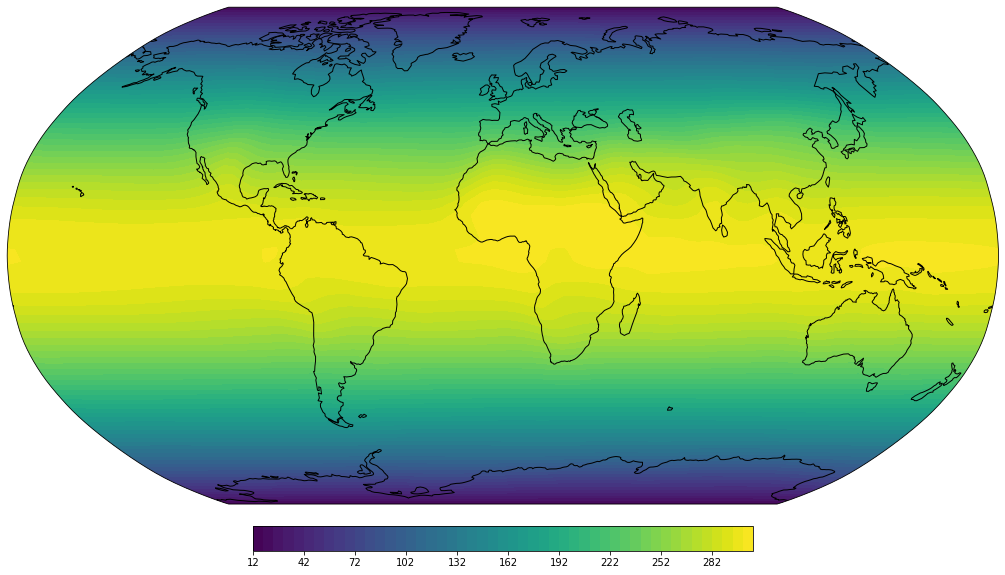

Limits: 12.360980565978371 306.0079907894464


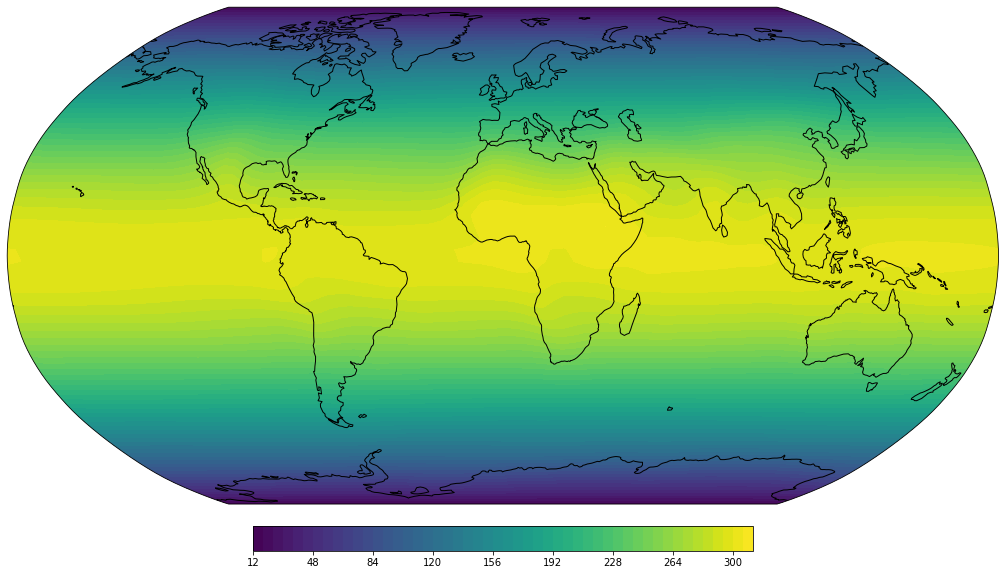

Limits: 12.36281862770981 306.0129669401156


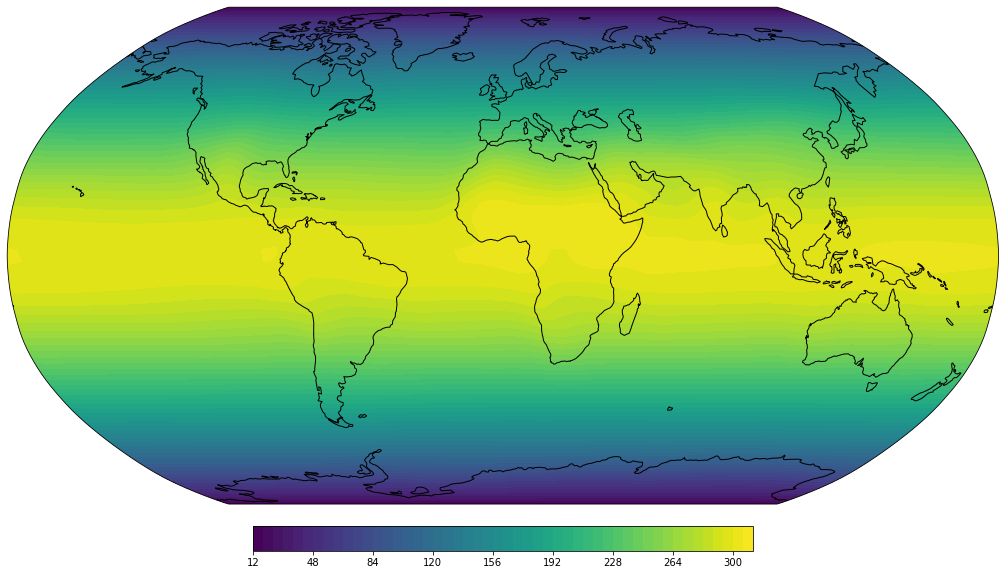

Limits: 12.338158808670816 306.0755744926129


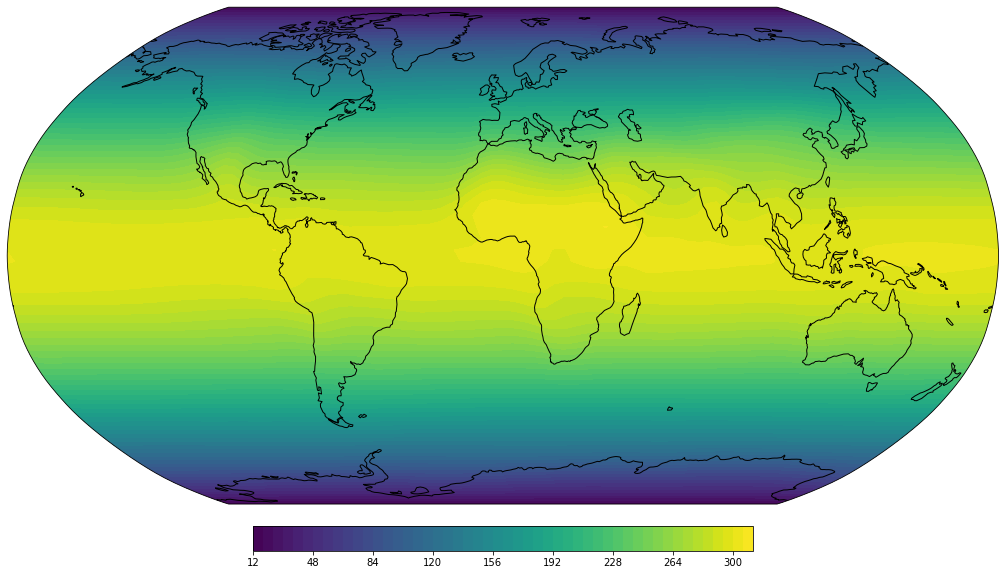

In [450]:
RobinsonPlotDev(dfcontrol,plt.cm.viridis, lower_limit=None, upper_limit=None, nlevs = 50)
RobinsonPlotDev(df52,plt.cm.viridis, lower_limit=None, upper_limit=None, nlevs = 50)
RobinsonPlotDev(dfSR,plt.cm.viridis, lower_limit=None, upper_limit=None, nlevs = 50)
RobinsonPlotDev(df10,plt.cm.viridis, lower_limit=None, upper_limit=None, nlevs = 50)

In [451]:

#Subtract one from other
subs52 = dfcontrol.copy()
subs52['weighted_temperature'] = dfcontrol.weighted_temperature - df52.weighted_temperature

subsSR = dfcontrol.copy()
subsSR['weighted_temperature'] = dfcontrol.weighted_temperature - dfSR.weighted_temperature

subs10 = dfcontrol.copy()
subs10['weighted_temperature'] = dfcontrol.weighted_temperature - df10.weighted_temperature


Limits: -0.04321252993509006 0.04908287899257857


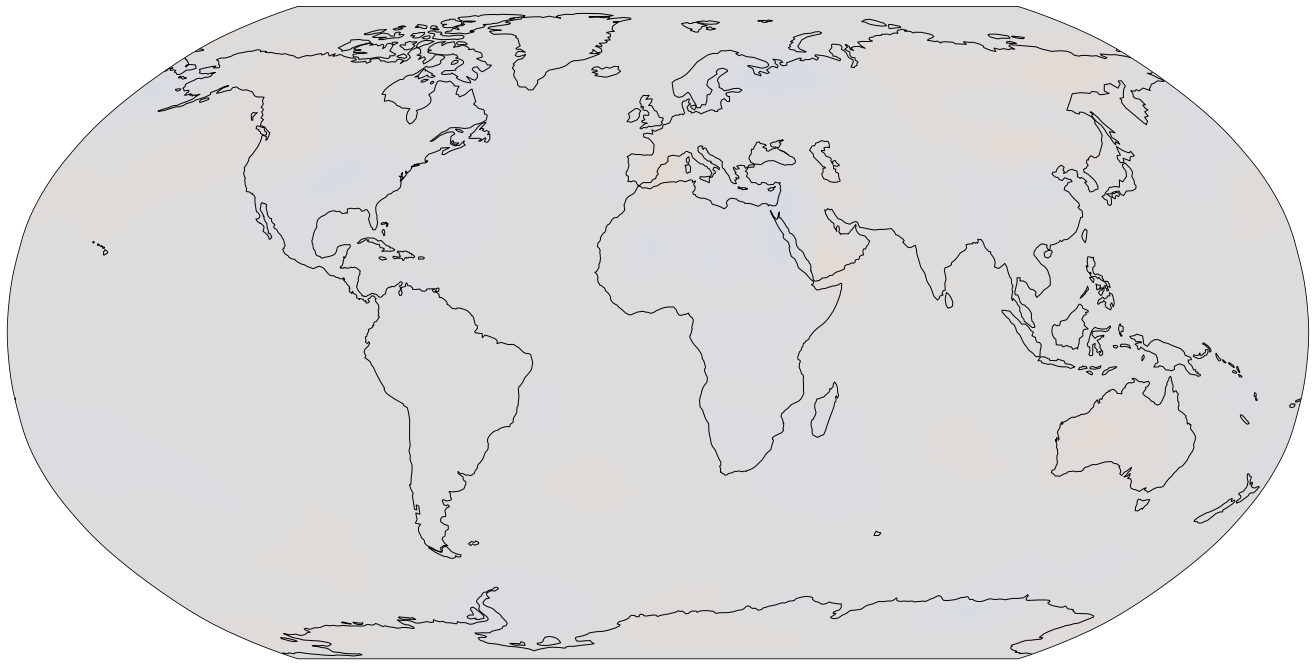

Limits: -0.1387530168425144 0.10741839715514345


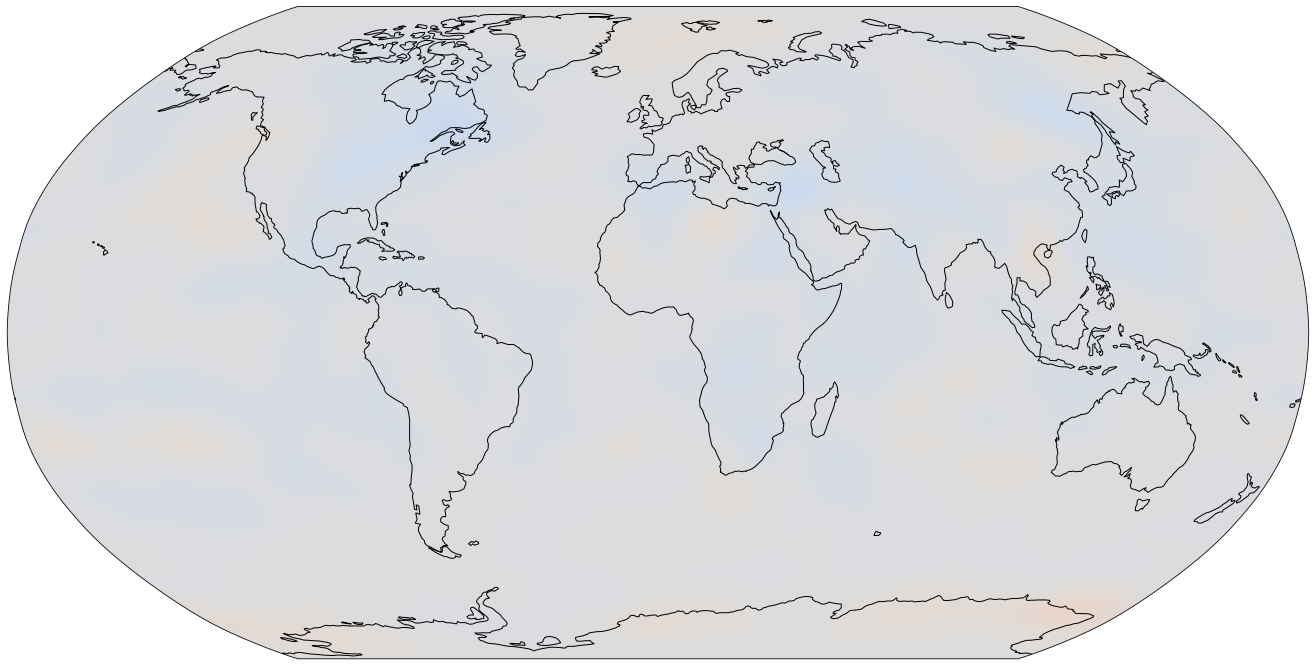

Limits: -0.770691705932478 0.3948343335523532


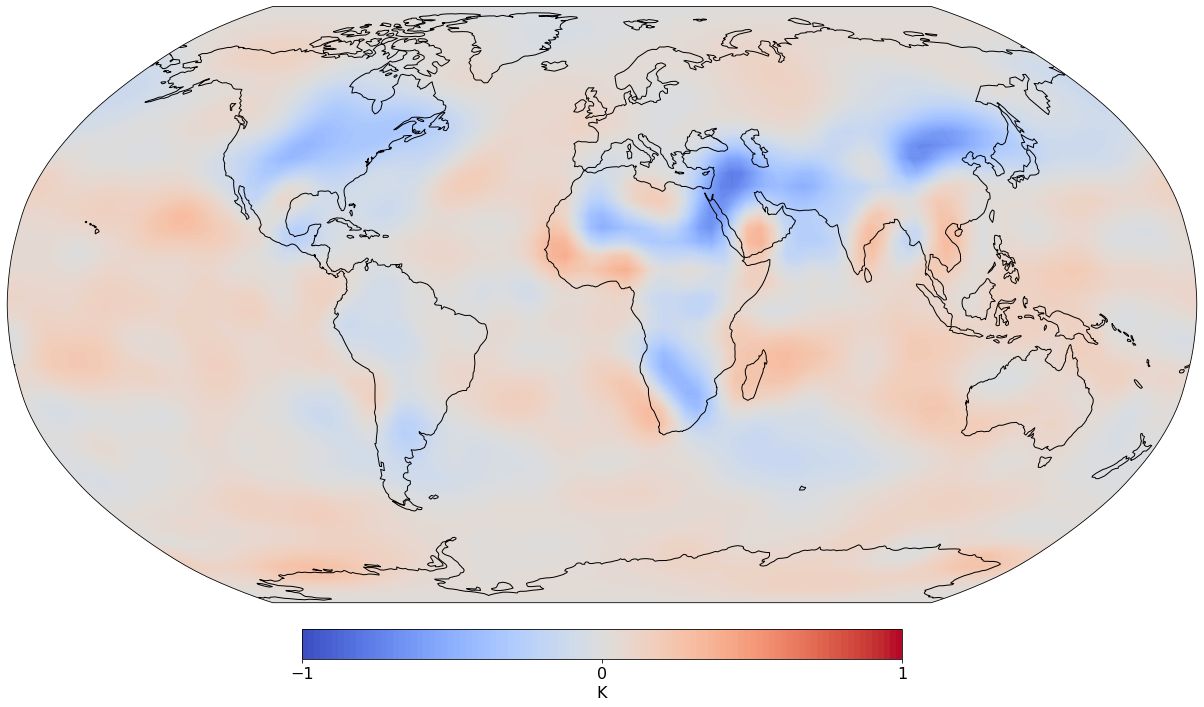

In [473]:
RobinsonPlotDev(subs52,plt.cm.coolwarm, lower_limit=-1, upper_limit=1, nlevs = 100,savefig=None,show_cbar=False)
RobinsonPlotDev(subsSR,plt.cm.coolwarm, lower_limit=-1, upper_limit=1, nlevs = 100,savefig=None,show_cbar=False)
RobinsonPlotDev(subs10,plt.cm.coolwarm, lower_limit=-1, upper_limit=1, nlevs = 100,savefig=None,show_cbar=True)

In [475]:
subs52.weighted_temperature.mean()

-0.0015294153435035825

In [478]:
subsSR.weighted_temperature.mean() / subs52.weighted_temperature.mean()

11.302664576364405

In [479]:
subs10.weighted_temperature.mean() / subs52.weighted_temperature.mean()

-13.397911457722277